# ลง package

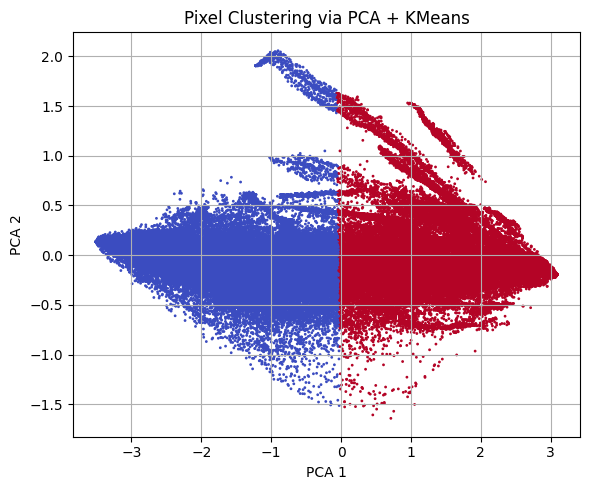

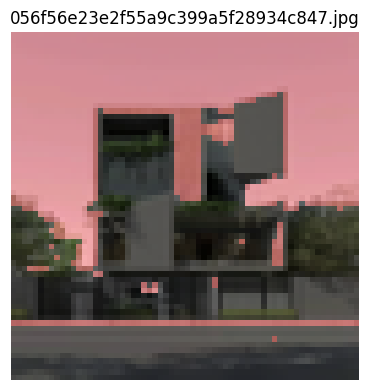

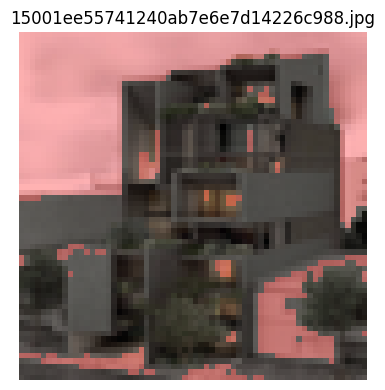

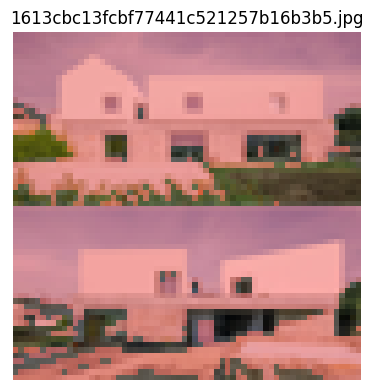

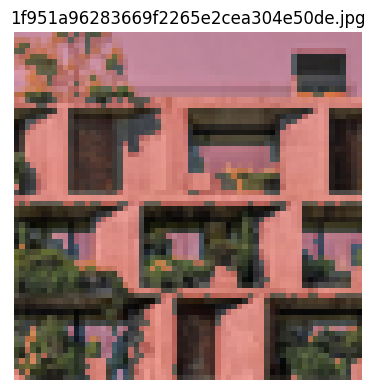

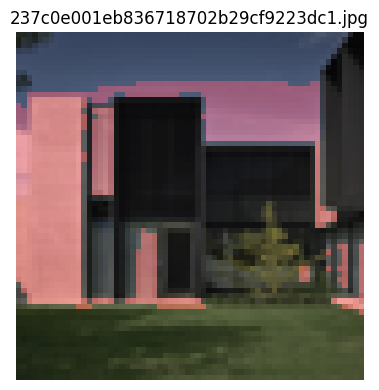

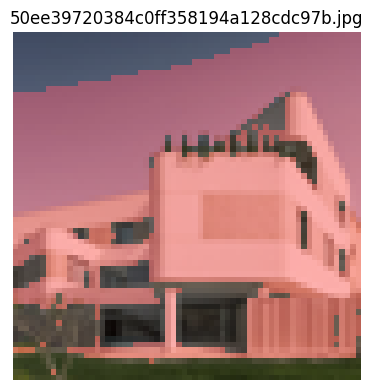

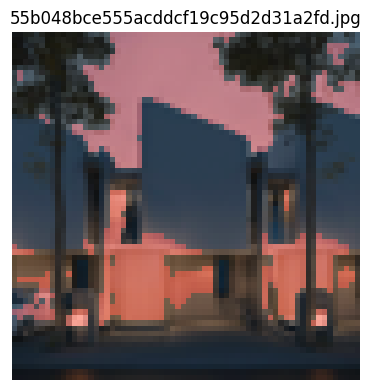

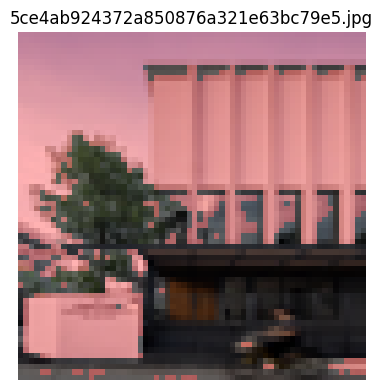

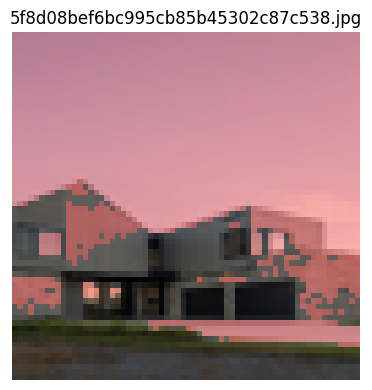

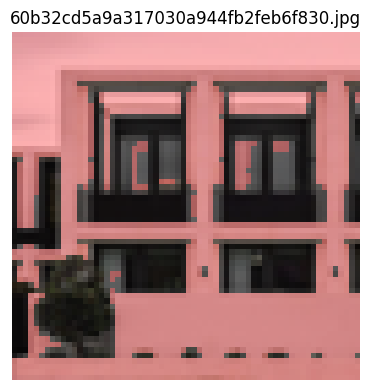

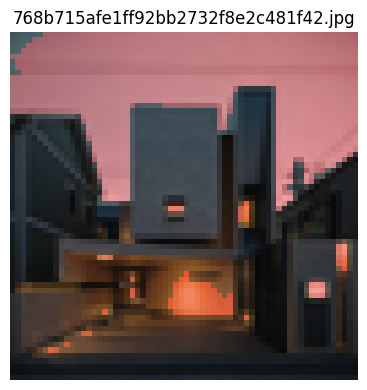

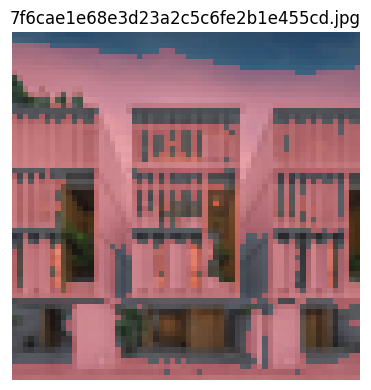

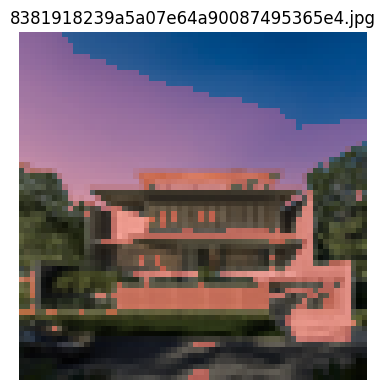

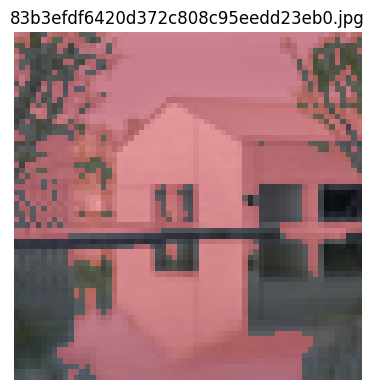

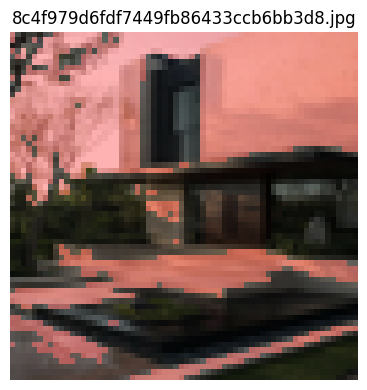

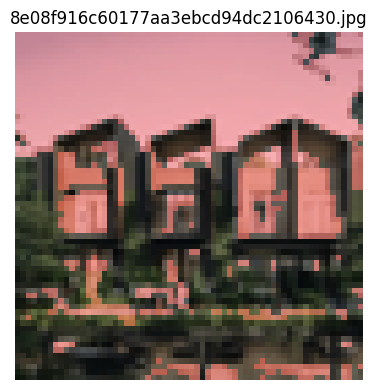

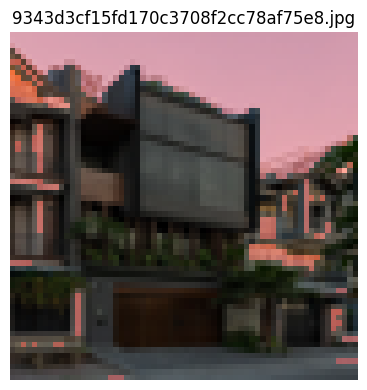

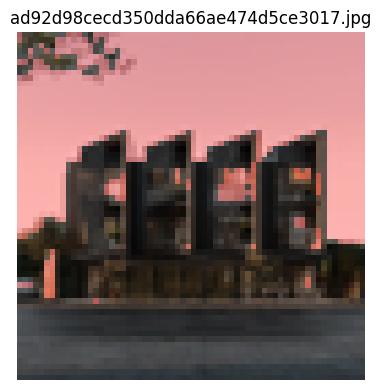

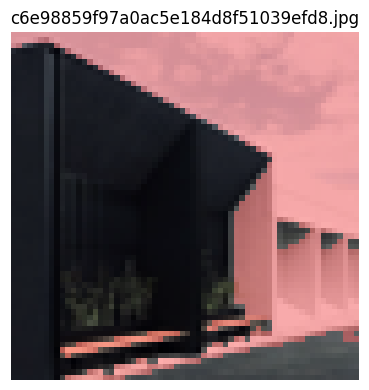

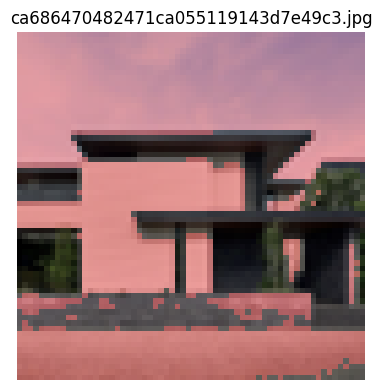

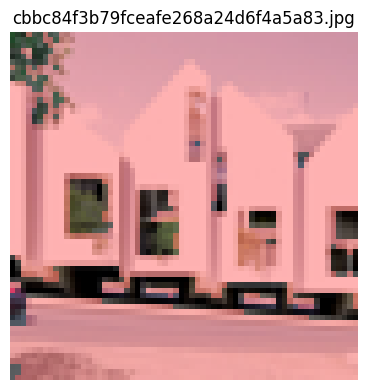

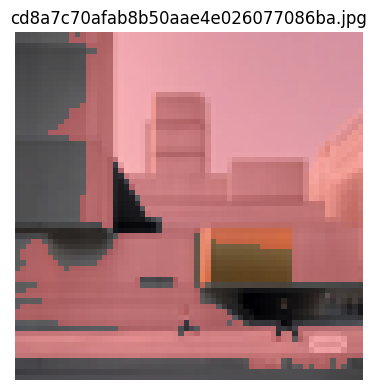

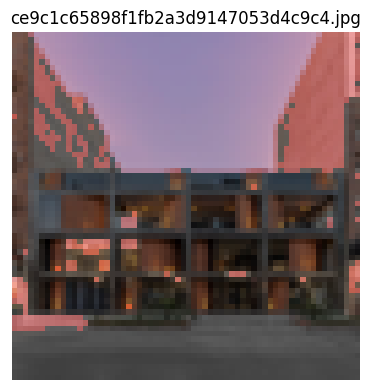

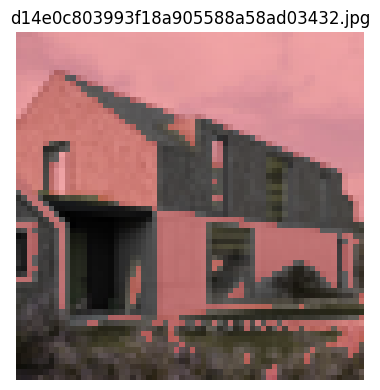

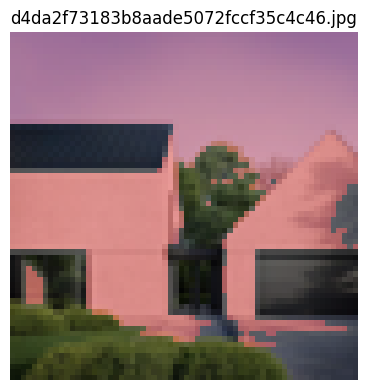

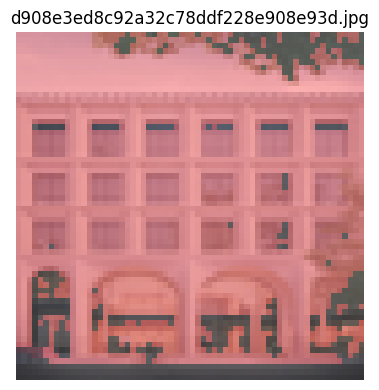

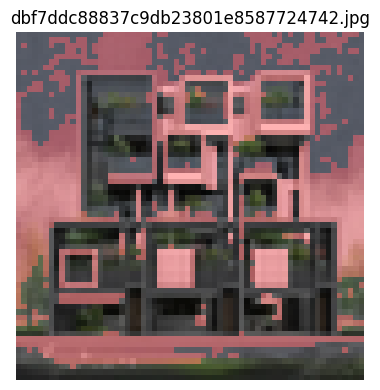

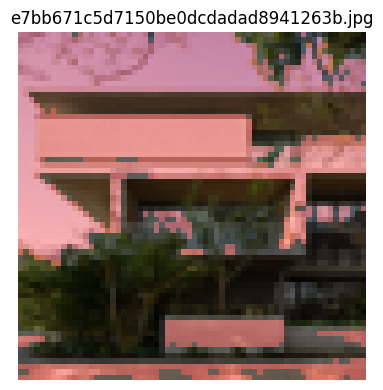

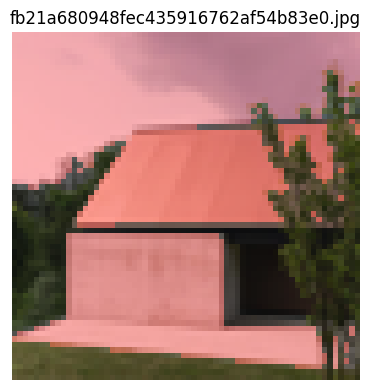

In [ ]:
import subprocess
import sys
import os

# Path to the venv's pip
venv_path = r"C:\Users\Toto\Documents\_PLP\RD-Trend\RD-Trend\.venv"
pip_path = os.path.join(venv_path, "Scripts", "pip.exe")

# Path to requirements.txt
req_path = os.path.join(os.getcwd(), "requirements.txt")

# Install all packages listed in requirements.txt using the venv's pip
subprocess.check_call([pip_path, "install", "-r", req_path])

print("✅ All libraries installed into your .venv successfully.")


# RUN code

In [ ]:
import os
import numpy as np
import cv2
from PIL import Image
from glob import glob
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# -------- CONFIG --------
image_dir = r'C:\Users\Toto\Documents\_PLP\RD-Trend\RD-Trend\dataset'
image_size = (64, 64)
n_clusters = 2

# -------- STEP 1: Load and preprocess images --------
image_paths = glob(os.path.join(image_dir, "*.jpg"))
images = []
names = []

for path in image_paths:
    try:
        img = Image.open(path).convert('RGB').resize(image_size)
        img_array = np.array(img).astype(np.uint8)
        images.append(img_array)
        names.append(os.path.basename(path))
    except Exception as e:
        print(f"❌ Error loading {path}: {e}")

# -------- STEP 2: Combine all pixels for clustering --------
all_pixels = np.vstack([img.reshape(-1, 3) for img in images])
scaler = StandardScaler()
pixels_scaled = scaler.fit_transform(all_pixels)

# PCA → ลดมิติเหลือ 2 เพื่อ plot ได้
pca = PCA(n_components=2)
pixels_pca = pca.fit_transform(pixels_scaled)

# -------- STEP 3: Cluster with KMeans --------
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(pixels_pca)

# -------- STEP 4: Plot PCA-clustered scatter plot --------
plt.figure(figsize=(6, 5))
plt.scatter(pixels_pca[:, 0], pixels_pca[:, 1], c=labels, cmap='coolwarm', s=1)
plt.title("Pixel Clustering via PCA + KMeans")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.tight_layout()
plt.show()

# -------- STEP 5: Reconstruct mask for each image --------
masks = []
offset = 0
for img in images:
    h, w = img.shape[:2]
    n_pixels = h * w
    mask = labels[offset:offset + n_pixels].reshape((h, w))
    masks.append(mask)
    offset += n_pixels

# -------- STEP 6: Safe display function --------
def safe_imshow(img, mask=None, title=''):
    if isinstance(img, Image.Image):
        img = np.array(img)
    elif not isinstance(img, np.ndarray):
        raise ValueError("Invalid image format")

    img = img.astype(np.uint8)

    if img.ndim == 2:
        cmap = 'gray'
    else:
        cmap = None

    if mask is not None:
        if isinstance(mask, Image.Image):
            mask = np.array(mask)
        mask = mask.astype(np.uint8)

        if mask.shape != img.shape[:2]:
            raise ValueError("Mask shape mismatch")

        color_mask = np.zeros_like(img)
        color_mask[mask == 1] = [255, 0, 0]  # red overlay
        img = cv2.addWeighted(img, 0.7, color_mask, 0.3, 0)

    plt.figure(figsize=(4, 4))
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# -------- STEP 7: Display all images with mask overlay --------
for i in range(len(images)):
    try:
        safe_imshow(images[i], mask=masks[i], title=names[i])
    except Exception as e:
        print(f"❌ Error displaying {names[i]}: {e}")


KeyboardInterrupt: 